# First Models Training & Classification

In this notebook, we'll generate a dataset with an spiral distribution of more than one class. We'll create some different models to train in this dataset and we'll visualize the different trained prediction distribution.

The goal of this notebook is understand how a linear model works and how it can improve if we use a hidden neural networks (with non-linear functions)

## Imports and configuration

In [1]:
import random
import torch
from torch import nn, optim
import math
from IPython import display

In [2]:
from res.plot_lib import plot_data, plot_model, set_default

In [3]:
set_default()

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device : {device}")

Device : cuda:0


## Generate Dataset

Define the generation parameters

In [5]:
# Intialize the seed of the randomn
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

N = 1000  # num_samples_per_class
D = 2     # dimensions
C = 3     # num_classes
H = 100   # num_hidden_units

Generate datapoints following spiral distribution

In [6]:
# Zero matrixes
X = torch.zeros(N * C, D).to(device)                # Matrix to the X input point
y = torch.zeros(N * C, dtype=torch.long).to(device) # Matrix to the Y output classes

# Generate points for each class
for c in range(C):
    index = 0
    
    # Generate equidistance N points from 0 t0 1
    t = torch.linspace(0, 1, N)  
    
    # When c = 0 and t = 0: start of linspace
    # When c = 0 and t = 1: end of linspace
    # This inner_var is for the formula inside sin() and cos() like sin(inner_var) and cos(inner_Var)
    inner_var = torch.linspace(
        # When t = 0
        (2 * math.pi / C) * (c),
        # When t = 1
        (2 * math.pi / C) * (2 + c),
        N
    ) + torch.randn(N) * 0.2
    
    # Calculate the random point to X and Y following an spiral structure
    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((
            math.sin(inner_var[index]), math.cos(inner_var[index])
        ))
        y[ix] = c
        index += 1

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (3000, 2)
y: (3000,)


Plot the generated points

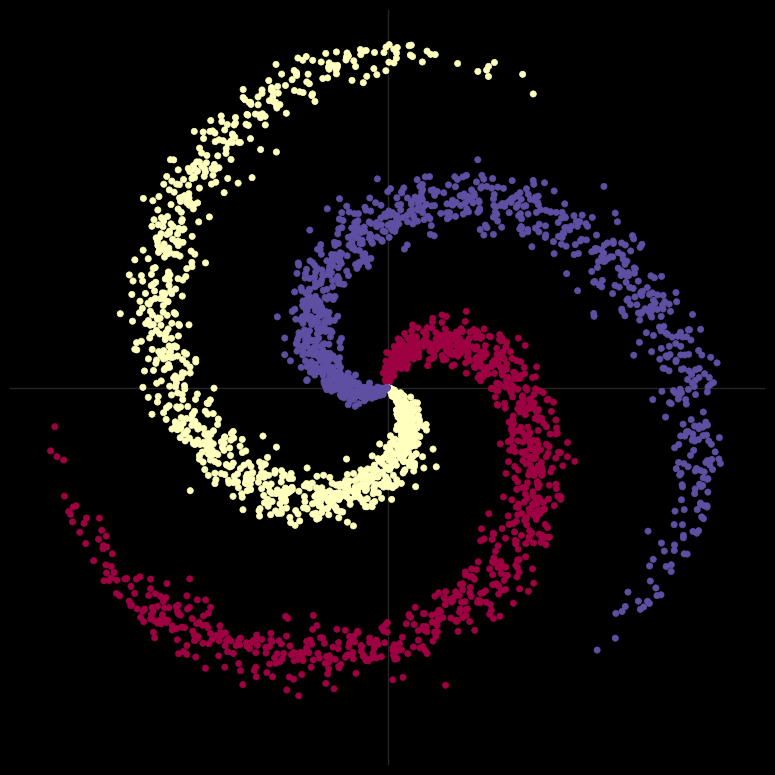

In [7]:
# visualise the data
plot_data(X, y)

## Train model

We train a network to predict the class of a point in basis the input examples (x,y)

### Linear model

This model only is training using linear transformations (rotation, reflexion and shrink) for the input dataset.

In [8]:
learning_rate = 1e-3
lambda_l2 = 1e-5

Define the model

In [9]:
# nn package to create our linear model
# each Linear module has a weight and bias
model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)
model.to(device) #Convert to CUDA

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

Train the linear model

In [10]:
# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    
    # torch.max args:
    # - input (Tensor): the input tensor.
    # - dim (int): the dimension to reduce.
    # out (tuple, optional): the result tuple of two output tensors (max, max_indices)
    score, predicted = torch.max(input=y_pred, dim=1)
    
    # accuracy = (num true positives / total predictions)
    acc = (y == predicted).sum().float() / len(y) 
    
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running the backward pass. (remove previous gradient calculations)
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 999, [LOSS]: 0.861541, [ACCURACY]: 0.504


Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=3, bias=True)
)


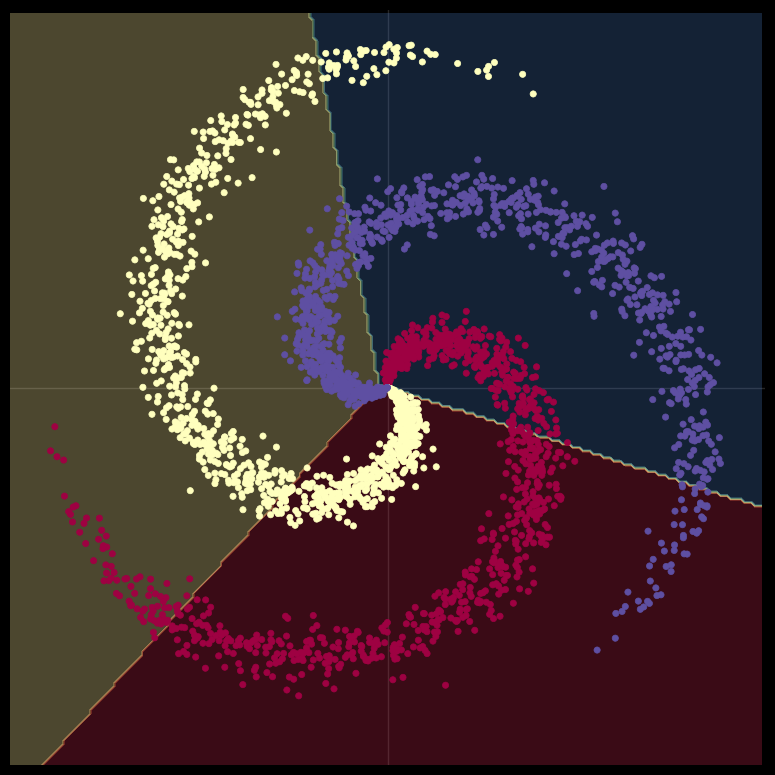

In [11]:
# Plot trained model
print(model)
plot_model(X, y, model)

A linear model, only can distribute the predictions in a linear way

### Two-layered network

This model includes a hidden layer with a non-linear function.

In [12]:
learning_rate = 1e-3
lambda_l2 = 1e-5

Define the model

In [13]:
# nn package to create our linear model
# each Linear module has a weight and bias

model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C)
)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

Model training 

In [14]:
# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 999, [LOSS]: 0.178408, [ACCURACY]: 0.949


Plot the model prediction distribution

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=3, bias=True)
)


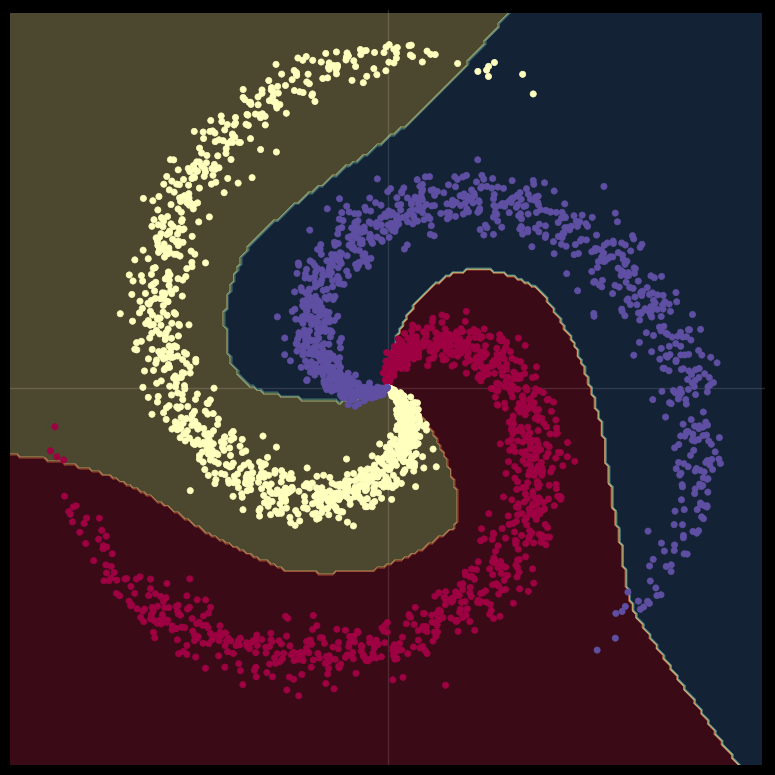

In [15]:
# Plot trained model
print(model)
plot_model(X, y, model)

A deep neural network includes non-linearity. This non-lineariaty allows curve the space in this way our prediction distribution can be non-linear

### Three-layered network

This model includes two hidden layers with a non-linear functions.

In [16]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [17]:
# nn package to create our linear model
# each Linear module has a weight and bias

model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(), 
    nn.Linear(H, C)
)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

In [18]:
# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 999, [LOSS]: 0.007688, [ACCURACY]: 0.999


Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=3, bias=True)
)


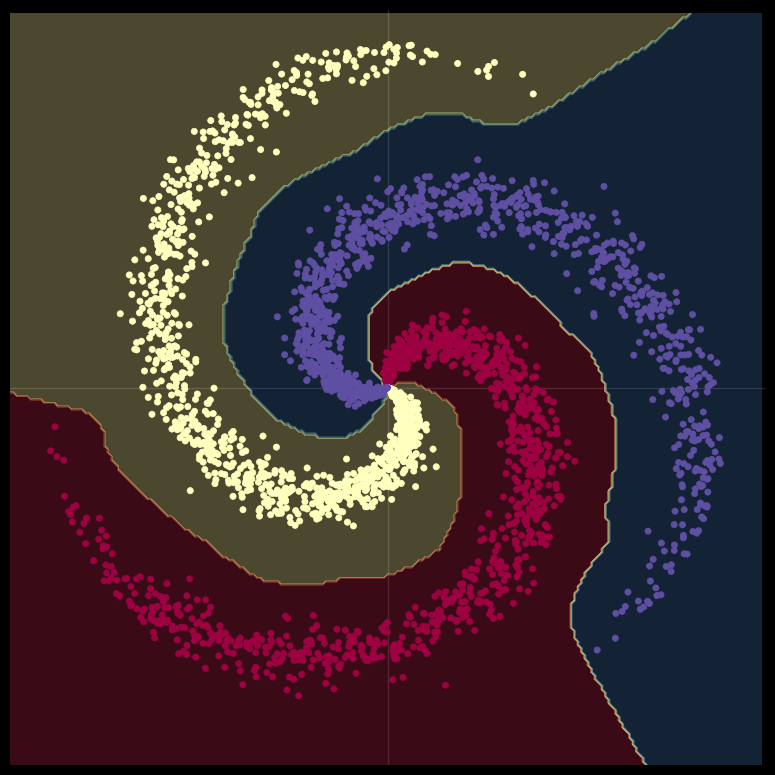

In [19]:
# Plot trained model
print(model)
plot_model(X, y, model)

With more hidden layers we have heavier models but we can get better prediction aproximation (is it worth? Trial and error. Furthermore, in next lessons we'll learn some tips.)

### Tests with the models

In [20]:
N = 1000  # num_samples_per_class
D = 2     # dimensions
C = 3     # num_classes
H = 200     # num_hidden_units

In [21]:
learning_rate = 1e-4
lambda_l2 = 1e-5

# nn package to create our linear model
# each Linear module has a weight and bias

# model = nn.Sequential(
#     nn.Linear(D, 100),
#     nn.Tanh(),
#     nn.Linear(100, H),
#     nn.Tanh(), 
#     nn.Linear(H, H),
#     nn.Tanh(), 
#     nn.Linear(H, H),
#     nn.Tanh(), 
#     nn.Linear(H, H),
#     nn.Tanh(), 
#     nn.Linear(H, H),
#     nn.Tanh(), 
#     nn.Linear(H, H),
#     nn.Tanh(), 
#     nn.Linear(H, H),
#     nn.Tanh(), 
#     nn.Linear(H, H),
#     nn.Tanh(), 
#     nn.Linear(H, H),
#     nn.Tanh(), 
#     nn.Linear(H, H),
#     nn.Tanh(), 
#     nn.Linear(H, H),
#     nn.Tanh(), 
#     nn.Linear(H, H),
#     nn.Tanh(), 
#     nn.Linear(H, H),
#     nn.Tanh(), 
#     nn.Linear(H, H),
#     nn.Tanh(), 
#     nn.Linear(H, H),
#     nn.Tanh(), 
#     nn.Linear(H, H),
#     nn.Tanh(), 
#     nn.Linear(H, H),
#     nn.Tanh(), 
#     nn.Linear(H, 100),
#     nn.Tanh(), 
#     nn.Linear(100, C)
# )

model = nn.Sequential(
    nn.Linear(D, 240),
    nn.ReLU(),
    nn.Linear(240, 220),
    nn.ReLU(), 
    nn.Linear(220, 200),
    nn.ReLU(), 
    nn.Linear(200, 180),
    nn.ReLU(), 
    nn.Linear(180, 160),
    nn.ReLU(), 
    nn.Linear(160, 140),
    nn.ReLU(), 
    nn.Linear(140, 120),
    nn.ReLU(), 
    nn.Linear(120, 100),
    nn.ReLU(), 
    nn.Linear(100, 80),
    nn.ReLU(), 
    nn.Linear(80, 60),
    nn.ReLU(), 
    nn.Linear(60, 50),
    nn.ReLU(), 
    nn.Linear(50, 30),
    nn.ReLU(), 
    nn.Linear(30, 10),
    nn.ReLU(), 
    nn.Linear(10, C)
)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# e = 1.  # plotting purpose

In [22]:
import copy
from matplotlib.pyplot import show

# Training
for t in range(55000):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()
    
#     if t % 1000 == 0:
#         display.clear_output(wait=True)
#         print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
#         pltmodel = copy.deepcopy(model)
#         plot_model(X.detach().clone(), y.detach().clone(), pltmodel)
#         show()

[EPOCH]: 54999, [LOSS]: 0.006236, [ACCURACY]: 0.997


Sequential(
  (0): Linear(in_features=2, out_features=240, bias=True)
  (1): ReLU()
  (2): Linear(in_features=240, out_features=220, bias=True)
  (3): ReLU()
  (4): Linear(in_features=220, out_features=200, bias=True)
  (5): ReLU()
  (6): Linear(in_features=200, out_features=180, bias=True)
  (7): ReLU()
  (8): Linear(in_features=180, out_features=160, bias=True)
  (9): ReLU()
  (10): Linear(in_features=160, out_features=140, bias=True)
  (11): ReLU()
  (12): Linear(in_features=140, out_features=120, bias=True)
  (13): ReLU()
  (14): Linear(in_features=120, out_features=100, bias=True)
  (15): ReLU()
  (16): Linear(in_features=100, out_features=80, bias=True)
  (17): ReLU()
  (18): Linear(in_features=80, out_features=60, bias=True)
  (19): ReLU()
  (20): Linear(in_features=60, out_features=50, bias=True)
  (21): ReLU()
  (22): Linear(in_features=50, out_features=30, bias=True)
  (23): ReLU()
  (24): Linear(in_features=30, out_features=10, bias=True)
  (25): ReLU()
  (26): Linear(in_fea

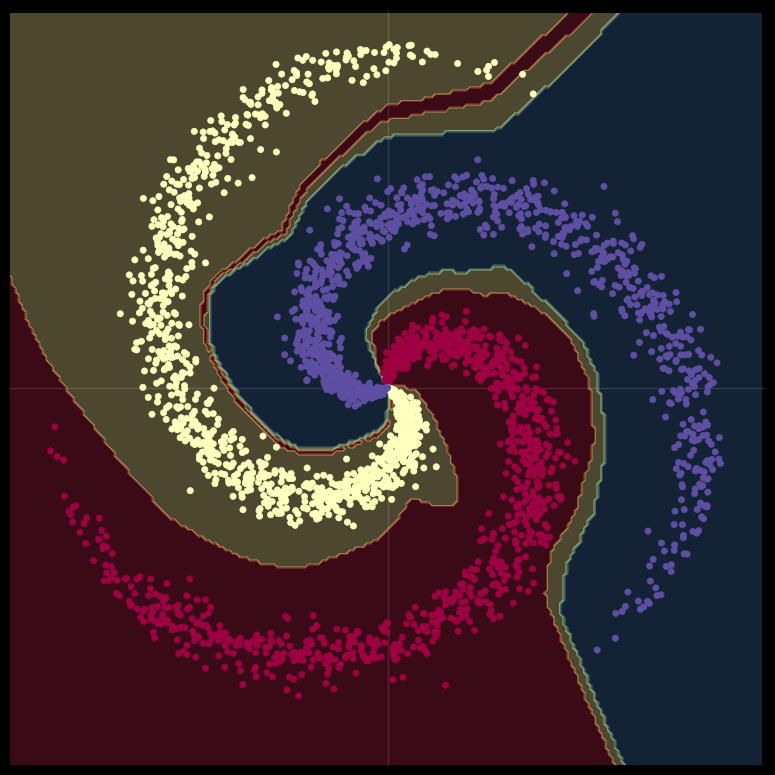

In [23]:
# Plot trained model
print(model)
plot_model(X, y, model)